In [19]:
import librosa
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scripts import setup
from scripts.extract_audio_features import extract_zcr, extract_loudness, extract_rhythm, create_target_variable, pad_audio
from scripts.load_data import load_full_audio

In [20]:
gt_211 =  pd.read_csv("../ground_truth_data/GroundTruth_Muppets-02-01-01.csv", sep=";")
gt_244 =  pd.read_csv("../ground_truth_data/GroundTruth_Muppets-02-04-04.csv", sep=";")
gt_343 =  pd.read_csv("../ground_truth_data/GroundTruth_Muppets-03-04-03.csv", sep=";")

In [21]:
video_path = "../ground_truth_data/Muppets-02-01-01.avi"

In [22]:
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
intro = 15 * fps
gt_211_nointro = gt_211[gt_211["Frame_number"] >= (intro - 1)].reset_index(drop=True)

In [23]:
muppet_files = {"Muppets-02-01-01.avi": "Muppets-02-01-01.csv", 
                "Muppets-02-04-04.avi": "Muppets-02-04-04.csv",
                "Muppets-03-04-03.avi": "Muppets-03-04-03.csv"}

data_path = "../ground_truth_data"
output_dir = "../ground_truth_data"

#setup.extract_audio(muppet_files, data_path, output_dir, sampling_rate=44100)

# Pigs audio

In [24]:
audio_path = "../ground_truth_data/Muppets-02-01-01.wav"

In [25]:
gt_211_nointro.loc[gt_211_nointro["Audio_Pigs"] == 1]

,Video,Frame_number,Kermit,Pigs,Audio_Pigs,Cook,Audio_Cook,StatlerWaldorf,Audio_StatlerWaldorf,Audio_MissPiggy
18143,211,18517,0,1,1,0,0,0,0,1
18144,211,18518,0,1,1,0,0,0,0,1
18145,211,18519,0,1,1,0,0,0,0,1
18146,211,18520,0,1,1,0,0,0,0,1
18147,211,18521,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
19159,211,19533,0,1,1,0,0,0,0,1
19160,211,19534,0,1,1,0,0,0,0,1
19161,211,19535,0,1,1,0,0,0,0,1
19162,211,19536,0,1,1,0,0,0,0,1


In [26]:
# split into train+validation and test set
train_val_annotations, test_annotations = train_test_split(gt_211, test_size=0.2, random_state=42, stratify=gt_211["Audio_Pigs"])
                                            
# split train+validation into train and validation sets
train_annotations, val_annotations = train_test_split(train_val_annotations, test_size=0.25, random_state=42) 

In [27]:
# Define constants
AUDIO_SAMPLING_RATE = 44100
FRAMES_PER_SECOND = 25
# Calculate expected length
expected_length = int(AUDIO_SAMPLING_RATE / FRAMES_PER_SECOND)

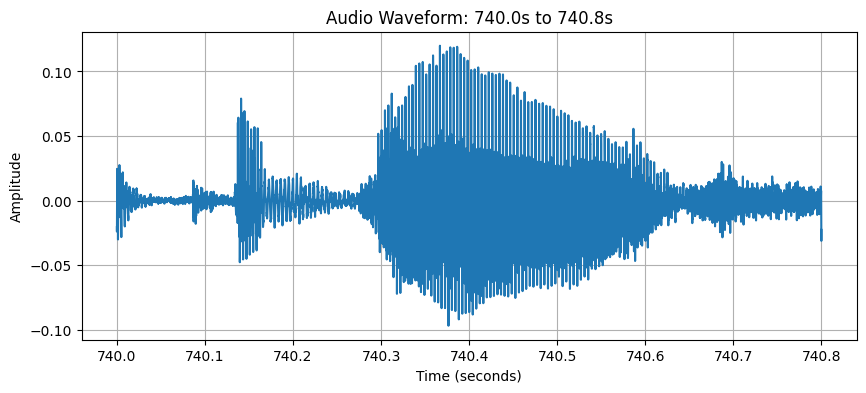

In [28]:

# Frame numbers for the range
frame_start = 18500
frame_end = 18520
fps = 25

# Convert frame numbers to timestamps (in seconds)
timestamp_start = frame_start / fps
timestamp_end = frame_end / fps

# Load audio file using librosa
audio, sr = librosa.load(audio_path, sr=None)  # Use the original sampling rate

# Convert timestamps to samples
start_sample = int(timestamp_start * sr)
end_sample = int(timestamp_end * sr)

# Extract the audio segment
audio_segment = audio[start_sample:end_sample]

# Plot the waveform of the extracted audio segment
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(timestamp_start, timestamp_end, len(audio_segment)), audio_segment)
plt.title(f"Audio Waveform: {timestamp_start}s to {timestamp_end}s")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


## MFCC

In [29]:
# Define constants
AUDIO_SAMPLING_RATE = 44100
FRAMES_PER_SECOND = 25
# Calculate expected length
EXPECTED_LENGTH = int(AUDIO_SAMPLING_RATE / FRAMES_PER_SECOND)

In [30]:
audio_data = load_full_audio("../ground_truth_data")

Loaded 3 audio files.


In [31]:
def pad_audio(audio):
    """
    Pad or trim audio to match the expected length.

    Parameters:
    - audio (ndarray): Audio signal.

    Returns:
    - ndarray: Padded or trimmed audio signal.
    """
    if len(audio) < EXPECTED_LENGTH:
        padding = EXPECTED_LENGTH - len(audio)
        audio = np.pad(audio, (0, padding), mode="constant")
    elif len(audio) > EXPECTED_LENGTH:
        audio = audio[:EXPECTED_LENGTH]
    return audio

In [32]:
def extract_mfcc(audio_data, n_mfcc=20):
    """
    Extract MFCC (Mel-Frequency Cepstral Coefficients) features for each audio file.

    Parameters:
    - audio_data (list): List of dictionaries with audio data and metadata.
    - n_mfcc (int): Number of MFCC coefficients to extract.

    Returns:
    - mfcc_features (list): List of MFCC features for each audio file.
    """
    mfcc_features = []

    for audio_entry in audio_data:
        try:
            audio = audio_entry['audio']

            # Pad and normalize audio
            #audio = pad_audio(audio)
            audio = librosa.util.normalize(audio)

            # Calculate MFCC
            mfcc = librosa.feature.mfcc(
                y=audio,
                sr=AUDIO_SAMPLING_RATE, 
                n_mfcc=n_mfcc,
                hop_length=EXPECTED_LENGTH,
                n_fft=EXPECTED_LENGTH
                )

            mfcc_features.append(mfcc)
        except Exception as e:
            print(f"Error processing {audio_entry['audio_file']}: {e}")
            mfcc_features.append(None)

    return mfcc_features

In [34]:
mfcc_features  = extract_mfcc(audio_data)
len(mfcc_features[0][0])

38672

# Cook audio

In [23]:
gt_211_nointro.loc[gt_211_nointro["Audio_Cook"] == 1]

,Video,Frame_number,Kermit,Pigs,Audio_Pigs,Cook,Audio_Cook,StatlerWaldorf,Audio_StatlerWaldorf,Audio_MissPiggy
28599,211,28973,0,0,0,1,1,0,0,0
28600,211,28974,0,0,0,1,1,0,0,0
28601,211,28975,0,0,0,1,1,0,0,0
28602,211,28976,0,0,0,1,1,0,0,0
28603,211,28977,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
29920,211,30294,0,0,0,1,1,0,0,0
29921,211,30295,0,0,0,1,1,0,0,0
29922,211,30296,0,0,0,1,1,0,0,0
29923,211,30297,0,0,0,1,1,0,0,0


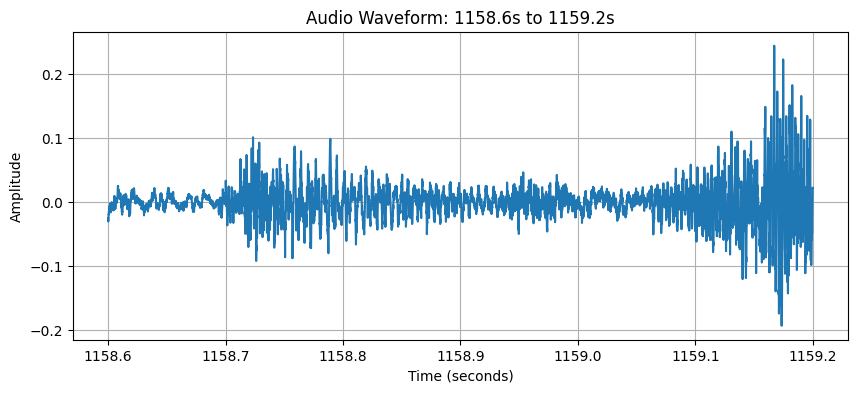

In [24]:
audio_path = "../ground_truth_data/Muppets-02-01-01.wav"

# Frame numbers for the range
frame_start = 28965
frame_end = 28980
fps = 25

# Convert frame numbers to timestamps (in seconds)
timestamp_start = frame_start / fps
timestamp_end = frame_end / fps

# Load audio file using librosa
audio, sr = librosa.load(audio_path, sr=None)  # Use the original sampling rate

# Convert timestamps to samples
start_sample = int(timestamp_start * sr)
end_sample = int(timestamp_end * sr)

# Extract the audio segment
audio_segment = audio[start_sample:end_sample]

# Plot the waveform of the extracted audio segment
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(timestamp_start, timestamp_end, len(audio_segment)), audio_segment)
plt.title(f"Audio Waveform: {timestamp_start}s to {timestamp_end}s")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Alignment

In [15]:
audio, sr = librosa.load(audio_path, sr=44100)  
len(audio)

In [16]:
len(audio)

68215997

In [17]:
68215997/(44100/25)

38671.20011337868

In [35]:
gt_211.shape #38681

(38681, 10)